# Case study of the december 6 2021 storm


---

**Author**: Olivier Chalifour
**Organisation**: UQAM
**Date**: 26 July 2021

---




In [77]:
"""
Import
"""
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import os
import pickle as pkl
import glob
import sys
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import cartopy.crs as ccrs  # Import cartopy ccrs
import cartopy.feature as cfeature  # Import cartopy common features
from matplotlib import animation
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import scipy.stats
import math
import time as time_mod
sys.path.insert(0, "/home/chalifour/code/master")
import fct_script.rpn_funcs_chris as rpn_chris
from fct_script.get_domain import get_domain_info
from fct_script.func_py import get_colormap_precip,categorical_cmap
from matplotlib.patches import Patch
# from func_py import get_proj_extent

try:
    import rpnpy.librmn.all as rmn  # Module to read RPN files
    from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
except ImportError as err:
    print(f"RPNPY can only be use on the server. It can't be use on a personal computer."
          f"\nError throw :{err}")

In [78]:
# Get event date

df_event_lenght = pd.read_csv('/upslope/chalifour/projet_maitrise/data_site_neige/dataframe_event_neige.csv',index_col=0)
df_event_lenght.sort_values(['mix_tot'], ascending=False,inplace=True)
print(df_event_lenght)

                  begin                  end    dt  dt_mix  max_mix_1h  \
9   2021-11-17 23:00:00  2021-11-19 01:00:00  26.0       8    2.489627   
14  2022-03-06 07:00:00  2022-03-07 06:00:00  23.0       6    3.696609   
10  2021-12-06 05:00:00  2021-12-07 10:00:00  29.0       6    2.874000   
13  2022-02-22 23:00:00  2022-02-23 10:00:00  11.0       5    2.866794   
15  2022-03-19 12:00:00  2022-03-21 10:00:00  46.0       7    1.019500   
3   2020-11-30 21:00:00  2020-12-01 12:00:00  15.0       1    4.929876   
7   2021-03-28 14:00:00  2021-03-29 12:00:00  22.0       3    3.657810   
8   2021-11-12 15:00:00  2021-11-13 05:00:00  14.0       2    1.694311   
11  2021-12-11 14:00:00  2021-12-12 10:00:00  20.0       4    1.469300   
18  2022-04-16 00:00:00  2022-04-16 06:00:00   6.0       1    2.894048   
0   2020-10-10 02:00:00  2020-10-10 09:00:00   7.0       1    2.875325   
1   2020-11-01 23:00:00  2020-11-02 06:00:00   7.0       3    0.977996   
20  2022-04-21 21:00:00  2022-04-22 07

---
---
# Time array

In [92]:
# event 1
date_1 = '2021-11-17 23'
f_hr_1 = 30
datetimeobject_1 = datetime.strptime(date_1, '%Y-%m-%d %H')
new_format_1 = datetimeobject_1.strftime('%Y%m%d')
format_rpn_file_1 = datetimeobject_1.strftime('%Y%m')

run_1 = pd.Timestamp(fr'{date_1}')


valid_time_1 = run_1 + pd.Timedelta(str(f_hr_1) + ' h')
timestamps_1 = pd.date_range(run_1, valid_time_1, freq='1 H')
time_1 = timestamps_1

timestamps_1_fig_minor = pd.date_range(run_1 + pd.Timedelta('1 h'), valid_time_1+ pd.Timedelta('6 h'), freq='6 H')
timestamps_1_fig_major = pd.date_range(run_1 - pd.Timedelta('23 h'), valid_time_1+ pd.Timedelta('1 h'), freq='24 H')[1:]

start_1 = run_1
end_1 = valid_time_1



# event 2
date_2 = '2021-12-06 05'
f_hr_2 = 30
datetimeobject_2 = datetime.strptime(date_2, '%Y-%m-%d %H')
new_format_2 = datetimeobject_2.strftime('%Y%m%d')
format_rpn_file_2 = datetimeobject_2.strftime('%Y%m')

run_2 = pd.Timestamp(fr'{date_2}')


valid_time_2 = run_2 + pd.Timedelta(str(f_hr_2) + ' h')
timestamps_2 = pd.date_range(run_2, valid_time_2, freq='1 H')
timestamps_2_fig_minor = pd.date_range(run_2 + pd.Timedelta('1 h'), valid_time_2+ pd.Timedelta('6 h'), freq='6 H')
timestamps_2_fig_major = pd.date_range(run_2 - pd.Timedelta('5 h'), valid_time_2+ pd.Timedelta('1 h'), freq='24 H')[1:]

time_2 = timestamps_2

start_2 = run_2
end_2 = valid_time_2
#event 3

date_3 = '2022-03-06 06'
f_hr_3 = 30

datetimeobject_3 = datetime.strptime(date_3, '%Y-%m-%d %H')
new_format_3 = datetimeobject_3.strftime('%Y%m%d')
format_rpn_file_3 = datetimeobject_3.strftime('%Y%m')

run_3 = pd.Timestamp(fr'{date_3}')


valid_time_3 = run_3 + pd.Timedelta(str(f_hr_3) + ' h')
timestamps_3 = pd.date_range(run_3, valid_time_3, freq='1 H')
time_3 = timestamps_3

timestamps_3_fig_minor = pd.date_range(run_3, valid_time_3, freq='6 H')
timestamps_3_fig_major = pd.date_range(run_3 - pd.Timedelta('6 h'), valid_time_3+ pd.Timedelta('1 h'), freq='24 H')[1:]

start_3 = run_3
end_3 = valid_time_3


---
---

# Important path

In [83]:
# Simulation Data path
# path_dict_sim_2_5km = '/BIG1/roberge/Output/GEM5/Cascades_CORDEX/CLASS/Safe_versions/Spinup/NAM-11m_ERA5_GEM5_CLASS_NV_NA_newP3-SCPF_SN8_20yrs'
# file_name_20211 = f'Samples/NAM-11m_ERA5_GEM5_CLASS_NV_NA_newP3-SCPF_SN8_20yrs_{format_rpn_file}'

path_dict_sim_2_5km = '/focus/roberge/Output/GEM5/SACHR/Cascades_CORDEX/CLASS/Spinup/ECan_2.5km_NAM11mP3_newP3_CLASS_DEEPoff_SHALon/Samples'
file_name_20211 = f'ECan_2.5km_NAM11mP3_newP3_CLASS_DEEPoff_SHALon_{format_rpn_file_1}'
path_202112 = [os.path.join(path_dict_sim_2_5km,file_name_20211)]

# file_name_202204 = f'Samples/Eastern_Canada_2.5km_ERA5_GEM5_newP3_CLASS_NEWVEG_CCI_NEWDIF_5yrs_202204'
# path_202112.append(os.path.join(path_dict_sim_2_5km,file_name_202204))
# Parcivel data path

# image output dir
image_output_dir = "/upslope/chalifour/projet_maitrise/fig/case_analysis"

In [84]:
# Important information
image_output_dpi = 150
# lat,lon foret momo
lat_momo = 47.322437368331876
lon_momo = -71.14730110000002

---
---
# Plot temporal
- temp
- precip
- phase
- vents

In [85]:
path_save_df = '/upslope/chalifour/projet_maitrise/dataframe_obs_formated'
dataframe_momo = pd.read_csv(path_save_df + f'/dataframe_momo_formated_2year.csv',
                                parse_dates=['date'])
dataframe_momo.set_index('date', inplace=True)
dataframe_momo_1= dataframe_momo.loc[time_1[0]:time_1[-1]]
dataframe_momo_2= dataframe_momo.loc[time_2[0]:time_2[-1]]
dataframe_momo_3= dataframe_momo.loc[time_3[0]:time_3[-1]]


In [86]:

phase_list = ['f_0','f_60','f_67','f_69','f_70']

# phase_str = ['None',  'Rain', 'Freezing rain', 'Mix of snow and rain','Snow']

# pType_color = ['k', 'tab:green', 'tab:red','tab:orange' ,'tab:blue',]

# phase_list_name = ['RN','FR','MX','SN']
phase_list_num = [0, 60, 67, 69,70]
# phase_name = ['Rain','Freezing\nRain','Mix of\nsnow and rain','Snow']
phase_list_name =['frac_liquide','frac_FZ','frac_mix_fr','frac_mix','frac_solide']
phase_name = ['Liquid', 'Freezing rain', 'Mix of Liquid and Solid\nwith FZ','Mix of Liquid and Solid','Solid']

pType_color = ['tab:green', 'tab:red','tab:purple','tab:orange' ,'tab:blue',]  # ['firebrick','lime',    'm',       'orange']#
dict_phase = {}

In [87]:
begin,end = '2021-10','2022-07'
# uqam et momo 11 km
#
# file_11km_Umomo = glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_UQAM_MOMO_sim_11kmP3_{begin.strip("-")}_{end.strip("-")}.csv'))
# dataframe_11km_Umomo = pd.read_csv(file_11km_Umomo[0], parse_dates=['time'])
# dataframe_11km_Umomo.set_index('time', inplace=True)
# with open('/upslope/chalifour/projet_maitrise/dataframe_obs_formated/altitude_dict_11km.pkl', 'rb') as f:
#     dict_alt_sim_11km = pkl.load(f)
#
# # uqam et momo 2p5 km
#
# file_2p5km_Umomo = glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_UQAM_MOMO_sim_2p5kmP3_{begin.strip("-")}_{end.strip("-")}.csv'))
# dataframe_2p5km_Umomo = pd.read_csv(file_2p5km_Umomo[0], parse_dates=['time'])
# dataframe_2p5km_Umomo.set_index('time', inplace=True)


path_save_df = '/upslope/chalifour/projet_maitrise/dataframe_obs_formated'
dataframe_11kmP3_uqammomo = pd.read_csv(
    path_save_df + f'/dataframe_11kmP3_Umomo_stat_formated_2year.csv', parse_dates=['time'])
dataframe_11kmP3_uqammomo.set_index('time', inplace=True)
dataframe_2p5kmP3_uqammomo = pd.read_csv(
    path_save_df + f'/dataframe_2p5kmP3_Umomo_stat_formated_2year.csv', parse_dates=['time'])
dataframe_2p5kmP3_uqammomo.set_index('time', inplace=True)


dataframe_11km_Umomo = dataframe_11kmP3_uqammomo.loc[dataframe_11kmP3_uqammomo['filename']=='NEIGE']
dataframe_11km_Umomo_1= dataframe_11km_Umomo.loc[time_1[0]:time_1[-1]]
dataframe_11km_Umomo_2= dataframe_11km_Umomo.loc[time_2[0]:time_2[-1]]
dataframe_11km_Umomo_3= dataframe_11km_Umomo.loc[time_3[0]:time_3[-1]]


    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_2p5km_Umomo = dataframe_2p5kmP3_uqammomo.loc[dataframe_2p5kmP3_uqammomo['filename']=='NEIGE']
dataframe_2p5km_Umomo_1= dataframe_2p5km_Umomo.loc[time_1[0]:time_1[-1]]
dataframe_2p5km_Umomo_2= dataframe_2p5km_Umomo.loc[time_2[0]:time_2[-1]]
dataframe_2p5km_Umomo_3= dataframe_2p5km_Umomo.loc[time_3[0]:time_3[-1]]


<ipython-input-93-e7123aac0879>:36: RuntimeWarning: invalid value encountered in true_divide
  phase_liq_1 = ((dataframe_momo_1['frac_liquide'].values + dataframe_momo_1['frac_FZ'].values)/(dataframe_momo_1['frac_FZ'].values+dataframe_momo_1['frac_liquide'].values) *v1)+val
<ipython-input-93-e7123aac0879>:37: RuntimeWarning: invalid value encountered in true_divide
  phase_mix_1 = ((dataframe_momo_1['frac_mix'].values+ dataframe_momo_1['frac_mix_fr'].values)/(dataframe_momo_1['frac_mix'].values+dataframe_momo_1['frac_mix_fr'].values) *v1)+val
<ipython-input-93-e7123aac0879>:38: RuntimeWarning: invalid value encountered in true_divide
  phase_sol_1 = ((dataframe_momo_1['frac_solide'].values/dataframe_momo_1['frac_solide'].values) *v1)+val
<ipython-input-93-e7123aac0879>:40: RuntimeWarning: invalid value encountered in true_divide
  phase_liq_2 = ((dataframe_momo_2['frac_liquide'].values + dataframe_momo_2['frac_FZ'].values)/(dataframe_momo_2['frac_FZ'].values+dataframe_momo_2['frac_liqu

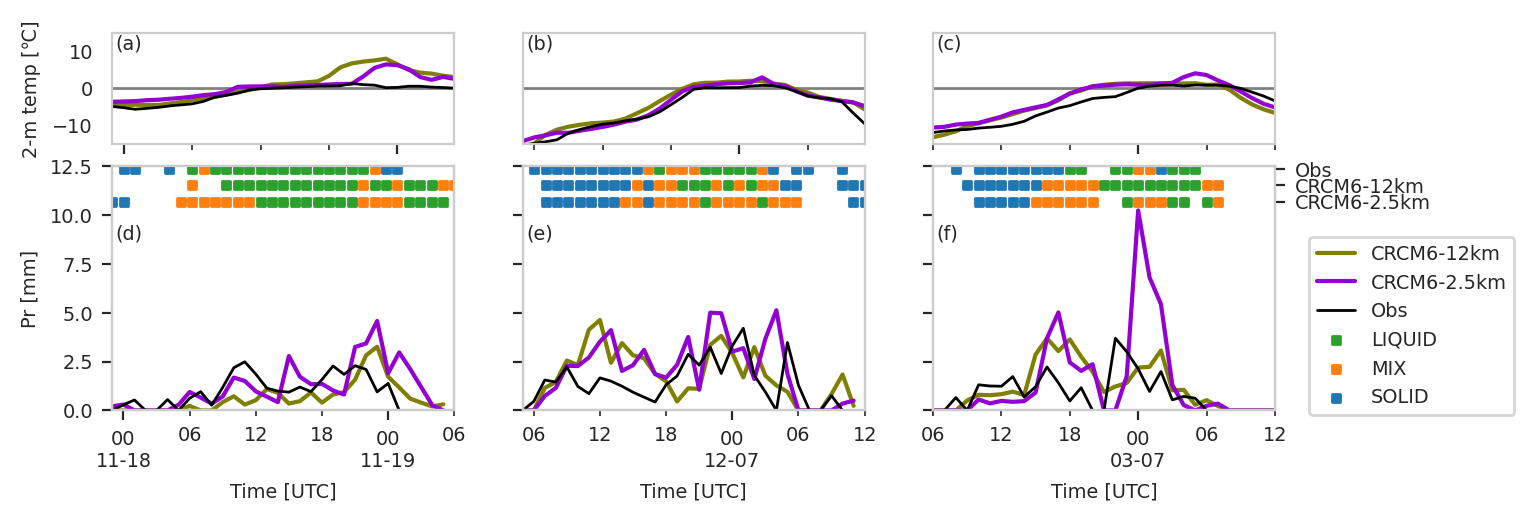

In [93]:
# Checker car c'est bizarre le code metar 60 qui est toujours retourmer meme en janvier le 18. Donc en parler à vincent.

a_trans=0.7

fig = plt.figure(facecolor='white',dpi=200,figsize=(7.5,2.5))
# figsize=figsize
# Set projection defined by the cartopy object
spec = fig.add_gridspec(nrows=3,ncols=3,)
ax_1_tt = fig.add_subplot(spec[0,0])
# ax_1_bia = ax_1_tt.twinx()
ax_1_pr = fig.add_subplot(spec[1:3,0])
ax_1_ph = ax_1_pr.twinx()

ax_2_tt= fig.add_subplot(spec[0,1])
# ax_2_bia = ax_2_tt.twinx()
ax_2_pr= fig.add_subplot(spec[1:3,1])
ax_2_ph = ax_2_pr.twinx()



ax_3_tt = fig.add_subplot(spec[0,2])
# ax_3_bia = ax_3_tt.twinx()
ax_3_pr = fig.add_subplot(spec[1:3,2])
ax_3_ph = ax_3_pr.twinx()

ax_1_tt.sharex(ax_1_pr)
ax_2_tt.sharex(ax_2_pr)
ax_3_tt.sharex(ax_3_pr)

ax_1_ph.sharex(ax_1_pr)
ax_2_ph.sharex(ax_2_pr)
ax_3_ph.sharex(ax_3_pr)

val = 0.25
v1=3.5
phase_liq_1 = ((dataframe_momo_1['frac_liquide'].values + dataframe_momo_1['frac_FZ'].values)/(dataframe_momo_1['frac_FZ'].values+dataframe_momo_1['frac_liquide'].values) *v1)+val
phase_mix_1 = ((dataframe_momo_1['frac_mix'].values+ dataframe_momo_1['frac_mix_fr'].values)/(dataframe_momo_1['frac_mix'].values+dataframe_momo_1['frac_mix_fr'].values) *v1)+val
phase_sol_1 = ((dataframe_momo_1['frac_solide'].values/dataframe_momo_1['frac_solide'].values) *v1)+val

phase_liq_2 = ((dataframe_momo_2['frac_liquide'].values + dataframe_momo_2['frac_FZ'].values)/(dataframe_momo_2['frac_FZ'].values+dataframe_momo_2['frac_liquide'].values) *v1)+val
phase_mix_2 = ((dataframe_momo_2['frac_mix'].values+ dataframe_momo_2['frac_mix_fr'].values)/(dataframe_momo_2['frac_mix'].values+dataframe_momo_2['frac_mix_fr'].values)*v1)+val
phase_sol_2 = ((dataframe_momo_2['frac_solide'].values/dataframe_momo_2['frac_solide'].values) *v1)+val

phase_liq_3 = ((dataframe_momo_3['frac_liquide'].values + dataframe_momo_3['frac_FZ'].values)/(dataframe_momo_3['frac_FZ'].values+dataframe_momo_3['frac_liquide'].values) *v1)+val
phase_mix_3 = ((dataframe_momo_3['frac_mix'].values+ dataframe_momo_3['frac_mix_fr'].values)/(dataframe_momo_3['frac_mix'].values+dataframe_momo_3['frac_mix_fr'].values)*v1)+val
phase_sol_3 = ((dataframe_momo_3['frac_solide'].values/dataframe_momo_3['frac_solide'].values) *v1)+val


#11 km
phase_liq_11km_1 = ((  dataframe_11km_Umomo_1['frac_liquide'].values +   dataframe_11km_Umomo_1['frac_FZ'].values)/( dataframe_11km_Umomo_1['frac_FZ'].values+ dataframe_11km_Umomo_1['frac_liquide'].values) *v1)
phase_mix_11km_1 = (( dataframe_11km_Umomo_1['frac_mix'].values+  dataframe_11km_Umomo_1['frac_mix_fr'].values)/( dataframe_11km_Umomo_1['frac_mix'].values+ dataframe_11km_Umomo_1['frac_mix_fr'].values) *v1)
phase_sol_11km_1 = (( dataframe_11km_Umomo_1['frac_solide'].values/ dataframe_11km_Umomo_1['frac_solide'].values) *v1)

phase_liq_11km_2 = (( dataframe_11km_Umomo_2['frac_liquide'].values +  dataframe_11km_Umomo_2['frac_FZ'].values)/( dataframe_11km_Umomo_2['frac_FZ'].values+ dataframe_11km_Umomo_2['frac_liquide'].values) *v1)
phase_mix_11km_2 = (( dataframe_11km_Umomo_2['frac_mix'].values+  dataframe_11km_Umomo_2['frac_mix_fr'].values)/( dataframe_11km_Umomo_2['frac_mix'].values+ dataframe_11km_Umomo_2['frac_mix_fr'].values)*v1)
phase_sol_11km_2 = (( dataframe_11km_Umomo_2['frac_solide'].values/ dataframe_11km_Umomo_2['frac_solide'].values) *v1)

phase_liq_11km_3 = (( dataframe_11km_Umomo_3['frac_liquide'].values +  dataframe_11km_Umomo_3['frac_FZ'].values)/( dataframe_11km_Umomo_3['frac_FZ'].values+ dataframe_11km_Umomo_3['frac_liquide'].values) *v1)
phase_mix_11km_3 = (( dataframe_11km_Umomo_3['frac_mix'].values+  dataframe_11km_Umomo_3['frac_mix_fr'].values)/( dataframe_11km_Umomo_3['frac_mix'].values+ dataframe_11km_Umomo_3['frac_mix_fr'].values)*v1)
phase_sol_11km_3 = (( dataframe_11km_Umomo_3['frac_solide'].values/ dataframe_11km_Umomo_3['frac_solide'].values) *v1)


#2.5 km
phase_liq_2p5km_1 = ((dataframe_2p5km_Umomo_1['frac_liquide'].values +   dataframe_2p5km_Umomo_1['frac_FZ'].values)/( dataframe_2p5km_Umomo_1['frac_FZ'].values+ dataframe_2p5km_Umomo_1['frac_liquide'].values) *v1)-val
phase_mix_2p5km_1 = ((dataframe_2p5km_Umomo_1['frac_mix'].values+  dataframe_2p5km_Umomo_1['frac_mix_fr'].values)/( dataframe_2p5km_Umomo_1['frac_mix'].values+ dataframe_2p5km_Umomo_1['frac_mix_fr'].values) *v1)-val
phase_sol_2p5km_1 = ((dataframe_2p5km_Umomo_1['frac_solide'].values/ dataframe_2p5km_Umomo_1['frac_solide'].values) *v1)-val

phase_liq_2p5km_2 = (( dataframe_2p5km_Umomo_2['frac_liquide'].values +  dataframe_2p5km_Umomo_2['frac_FZ'].values)/( dataframe_2p5km_Umomo_2['frac_FZ'].values+ dataframe_2p5km_Umomo_2['frac_liquide'].values) *v1)-val
phase_mix_2p5km_2 = (( dataframe_2p5km_Umomo_2['frac_mix'].values+  dataframe_2p5km_Umomo_2['frac_mix_fr'].values)/( dataframe_2p5km_Umomo_2['frac_mix'].values+ dataframe_2p5km_Umomo_2['frac_mix_fr'].values)*v1)-val
phase_sol_2p5km_2 = (( dataframe_2p5km_Umomo_2['frac_solide'].values/ dataframe_2p5km_Umomo_2['frac_solide'].values) *v1)-val

phase_liq_2p5km_3 = (( dataframe_2p5km_Umomo_3['frac_liquide'].values +  dataframe_2p5km_Umomo_3['frac_FZ'].values)/( dataframe_2p5km_Umomo_3['frac_FZ'].values+ dataframe_2p5km_Umomo_3['frac_liquide'].values) *v1)-val
phase_mix_2p5km_3 = (( dataframe_2p5km_Umomo_3['frac_mix'].values+  dataframe_2p5km_Umomo_3['frac_mix_fr'].values)/( dataframe_2p5km_Umomo_3['frac_mix'].values+ dataframe_2p5km_Umomo_3['frac_mix_fr'].values)*v1)-val
phase_sol_2p5km_3 = (( dataframe_2p5km_Umomo_3['frac_solide'].values/ dataframe_2p5km_Umomo_3['frac_solide'].values) *v1)-val


# ls4=ax_1_bia.plot(dataframe_11km_Umomo_1.index,dataframe_11km_Umomo_1['TT']-dataframe_momo_1['temp_moy'],label='Biais\nCRCM6-12km',color='tab:red',linestyle='-', zorder=-999)
# ls5=ax_1_bia.plot(dataframe_2p5km_Umomo_1.index,dataframe_2p5km_Umomo_1['TT']-dataframe_momo_1['temp_moy'],label='Biais\nCRCM6-2.5km',color='tab:red',linestyle='-.', zorder=-999)


ls1=ax_1_tt.plot(dataframe_11km_Umomo_1.index,dataframe_11km_Umomo_1['TT'],label='CRCM6-12km',color='olive', )
ls2=ax_1_tt.plot(dataframe_2p5km_Umomo_1.index,dataframe_2p5km_Umomo_1['TT'],label='CRCM6-2.5km',color='darkviolet', )
ls3=ax_1_tt.plot(dataframe_momo_1.index,dataframe_momo_1['temp_moy'] ,label='Obs',color='k',  linewidth=1, )

# ls4=ax_2_bia.plot(dataframe_11km_Umomo_2.index,dataframe_11km_Umomo_2['TT']-dataframe_momo_2['temp_moy'],label='Biais\nCRCM6-12km',color='tab:red',linestyle='-', zorder=-999)
# ls5=ax_2_bia.plot(dataframe_2p5km_Umomo_2.index,dataframe_2p5km_Umomo_2['TT']-dataframe_momo_2['temp_moy'],label='Biais\nCRCM6-2.5km',color='tab:red',linestyle='-.', zorder=-999)

ls1=ax_2_tt.plot(dataframe_11km_Umomo_2.index,dataframe_11km_Umomo_2['TT'],label='CRCM6-12km',color='olive', )
ls2=ax_2_tt.plot(dataframe_2p5km_Umomo_2.index,dataframe_2p5km_Umomo_2['TT'],label='CRCM6-2.5km',color='darkviolet', )
ls3=ax_2_tt.plot(dataframe_momo_2.index,dataframe_momo_2['temp_moy'] ,label='Obs',color='k',  linewidth=1, )

# ls4=ax_3_bia.plot(dataframe_11km_Umomo_3.index,dataframe_11km_Umomo_3['TT']-dataframe_momo_3['temp_moy'],label='Biais\nCRCM6-12km',color='tab:red',linestyle='-', zorder=-999)
# ls5=ax_3_bia.plot(dataframe_2p5km_Umomo_3.index,dataframe_2p5km_Umomo_3['TT']-dataframe_momo_3['temp_moy'],label='Biais\nCRCM6-2.5km',color='tab:red',linestyle='-.', zorder=-999)

ls1=ax_3_tt.plot(dataframe_11km_Umomo_3.index,dataframe_11km_Umomo_3['TT'],label='CRCM6-12km',color='olive', )
ls2=ax_3_tt.plot(dataframe_2p5km_Umomo_3.index,dataframe_2p5km_Umomo_3['TT'],label='CRCM6-2.5km',color='darkviolet', )
ls3=ax_3_tt.plot(dataframe_momo_3.index,dataframe_momo_3['temp_moy'] ,label='Obs',color='k',  linewidth=1, )


#precip 

ls1_pr=ax_1_pr.plot(dataframe_11km_Umomo_1.index,dataframe_11km_Umomo_1['PR'],label='CRCM6-12km',color='olive', )
ls2_pr=ax_1_pr.plot(dataframe_2p5km_Umomo_1.index,dataframe_2p5km_Umomo_1['PR'],label='CRCM6-2.5km',color='darkviolet', )
ls3_pr=ax_1_pr.plot(dataframe_momo_1.index,dataframe_momo_1['precip_inst_geonor'] ,label='Obs',color='k',  linewidth=1, )

ls1_pr=ax_2_pr.plot(dataframe_11km_Umomo_2.index,dataframe_11km_Umomo_2['PR'],label='CRCM6-12km',color='olive', )
ls2_pr=ax_2_pr.plot(dataframe_2p5km_Umomo_2.index,dataframe_2p5km_Umomo_2['PR'],label='CRCM6-2.5km',color='darkviolet', )
ls3_pr=ax_2_pr.plot(dataframe_momo_2.index,dataframe_momo_2['precip_inst_geonor'] ,label='Obs',color='k',  linewidth=1, )

ls1_pr=ax_3_pr.plot(dataframe_11km_Umomo_3.index,dataframe_11km_Umomo_3['PR'],label='CRCM6-12km',color='olive', )
ls2_pr=ax_3_pr.plot(dataframe_2p5km_Umomo_3.index,dataframe_2p5km_Umomo_3['PR'],label='CRCM6-2.5km',color='darkviolet', )
ls3_pr=ax_3_pr.plot(dataframe_momo_3.index,dataframe_momo_3['precip_inst_geonor'] ,label='Obs',color='k',  linewidth=1, )

size = 7.5

s1=ax_1_ph.scatter(dataframe_momo_1.index,phase_liq_1, color='tab:green',marker='s',s=size,label='LIQUID')
s2=ax_1_ph.scatter(dataframe_momo_1.index,phase_liq_11km_1, color='tab:green',marker='s',s=size)
s3=ax_1_ph.scatter(dataframe_momo_1.index,phase_liq_2p5km_1, color='tab:green',marker='s',s=size)

ax_1_ph.scatter(dataframe_momo_1.index,phase_mix_1, color='tab:orange',marker='s',s=size)
ax_1_ph.scatter(dataframe_momo_1.index,phase_mix_11km_1, color='tab:orange',marker='s',s=size)
ax_1_ph.scatter(dataframe_momo_1.index,phase_mix_2p5km_1, color='tab:orange',marker='s',s=size)

ax_1_ph.scatter(dataframe_momo_1.index,phase_sol_1, color='tab:blue',marker='s',s=size)
ax_1_ph.scatter(dataframe_momo_1.index,phase_sol_11km_1, color='tab:blue',marker='s',s=size)
ax_1_ph.scatter(dataframe_momo_1.index,phase_sol_2p5km_1, color='tab:blue',marker='s',s=size)


ax_2_ph.scatter(dataframe_momo_2.index,phase_liq_2, color='tab:green',marker='s',s=size)
ax_2_ph.scatter(dataframe_momo_2.index,phase_liq_11km_2, color='tab:green',marker='s',s=size)
ax_2_ph.scatter(dataframe_momo_2.index,phase_liq_2p5km_2, color='tab:green',marker='s',s=size)

ax_2_ph.scatter(dataframe_momo_2.index,phase_mix_2, color='tab:orange',marker='s',s=size)
ax_2_ph.scatter(dataframe_momo_2.index,phase_mix_11km_2, color='tab:orange',marker='s',s=size)
ax_2_ph.scatter(dataframe_momo_2.index,phase_mix_2p5km_2, color='tab:orange',marker='s',s=size)

ax_2_ph.scatter(dataframe_momo_2.index,phase_sol_2, color='tab:blue',marker='s',s=size)
ax_2_ph.scatter(dataframe_momo_2.index,phase_sol_11km_2, color='tab:blue',marker='s',s=size)
ax_2_ph.scatter(dataframe_momo_2.index,phase_sol_2p5km_2, color='tab:blue',marker='s',s=size)

ax_3_ph.scatter(dataframe_momo_3.index,phase_liq_3, color='tab:green',marker='s',s=size,label='LIQUID')
ax_3_ph.scatter(dataframe_momo_3.index,phase_liq_11km_3, color='tab:green',marker='s',s=size)
ax_3_ph.scatter(dataframe_momo_3.index,phase_liq_2p5km_3, color='tab:green',marker='s',s=size)

ax_3_ph.scatter(dataframe_momo_3.index,phase_mix_3, color='tab:orange',marker='s',s=size,label='MIX')
ax_3_ph.scatter(dataframe_momo_3.index,phase_mix_11km_3, color='tab:orange',marker='s',s=size)
ax_3_ph.scatter(dataframe_momo_3.index,phase_mix_2p5km_3, color='tab:orange',marker='s',s=size)

ax_3_ph.scatter(dataframe_momo_3.index,phase_sol_3, color='tab:blue',marker='s',s=size,label='SOLID')
ax_3_ph.scatter(dataframe_momo_3.index,phase_sol_11km_3, color='tab:blue',marker='s',s=size,)
ax_3_ph.scatter(dataframe_momo_3.index,phase_sol_2p5km_3, color='tab:blue',marker='s',s=size,)

ax_1_tt.plot(dataframe_momo.index,np.zeros(len(dataframe_momo.index)),color='grey',linewidth=1,zorder=-999999)
ax_2_tt.plot(dataframe_momo.index,np.zeros(len(dataframe_momo.index)),color='grey',linewidth=1,zorder=-999999)
ax_3_tt.plot(dataframe_momo.index,np.zeros(len(dataframe_momo.index)),color='grey',linewidth=1,zorder=-999999)
ax_1_tt.set_ylabel('2-m temp [\u2103]',fontsize='x-small')
ax_1_pr.set_ylabel('Pr [mm]',fontsize='x-small')
for ax in [ax_1_tt,ax_2_tt,ax_3_tt]:
    ax.set_ylim(-15,15)
    ax.grid(False)
for ax in [ax_1_pr,ax_2_pr,ax_3_pr]:
    ax.set_ylim(0,12.5)
    ax.grid(False)


for ax in [ax_1_ph,ax_2_ph,ax_3_ph]:
    ax.set_ylim(0,3.8)
    ax.grid(False)
    
ax_2_tt.sharey(ax_1_tt)
ax_3_tt.sharey(ax_1_tt)
# ax_1_bia.sharey(ax_3_bia)
# ax_2_bia.sharey(ax_3_bia)


ax_2_pr.sharey(ax_1_pr)
ax_3_pr.sharey(ax_1_pr)
ax_1_ph.sharey(ax_3_ph)
ax_2_ph.sharey(ax_3_ph)


ax_1_tt.set_xlim(time_1[0],time_1[-1])
ax_2_tt.set_xlim(time_2[0],time_2[-1])
ax_3_tt.set_xlim(time_3[0],time_3[-1])

# ax_1_tt.set_xlim(time_1[0],time_1[-1])
# ax_2_tt.set_xlim(time_2[0],time_2[-1])
# ax_3_tt.set_xlim(time_3[0],time_3[-1])



# ax_3_bia.set_ylabel('Bias [\u2103]',fontsize='x-small')
# ax_1_bia.set_ylim(-10,10)
# ax_2_bia.set_ylim(-10,10)
# ax_3_bia.set_ylim(-10,10)

# ax_1_bia.grid(False)
# ax_2_bia.grid(False)
# ax_3_bia.grid(False)

ax_1_ph.grid(False)
ax_2_ph.grid(False)
ax_3_ph.grid(False)

ax_1_tt.tick_params(which="both",bottom=True,labelbottom=False)
ax_2_tt.tick_params(which="both",bottom=True,labelbottom=False,labelleft=False)
ax_3_tt.tick_params(which="both",bottom=True,labelbottom=False,labelleft=False)
# ax_1_bia.tick_params(which="both",bottom=True,labelbottom=False,labelright=False)
# ax_2_bia.tick_params(which="both",bottom=True,labelbottom=False,labelright=False)
# ax_3_bia.tick_params(which="both",bottom=True,labelbottom=False,labelleft=False)

ax_1_pr.tick_params(which="both",bottom=True,labelbottom=True)
ax_2_pr.tick_params(which="both",bottom=True,labelbottom=True,labelleft=False)
ax_3_pr.tick_params(which="both",bottom=True,labelbottom=True,labelleft=False)
ax_1_ph.tick_params(which="both",bottom=True,labelbottom=False,labelright=False,right=False)
ax_2_ph.tick_params(which="both",bottom=True,labelbottom=False,labelright=False,right=False)
ax_3_ph.tick_params(which="both",bottom=True,labelbottom=False,labelleft=False,right=True)

ax_1_tt.tick_params(axis='both', labelsize='x-small')
ax_2_tt.tick_params(axis='both', labelsize='x-small')
ax_3_tt.tick_params(axis='both', labelsize='x-small')


# ax_1_bia.tick_params(axis='both', labelsize='x-small')
# ax_2_bia.tick_params(axis='both', labelsize='x-small')
# ax_3_bia.tick_params(axis='both', labelsize='x-small')


ax_1_pr.tick_params(axis='both',which='both', labelsize='x-small')
ax_2_pr.tick_params(axis='both',which='both', labelsize='x-small')
ax_3_pr.tick_params(axis='both',which='both', labelsize='x-small')

ax_1_ph.tick_params(axis='both', labelsize='x-small')
ax_2_ph.tick_params(axis='both', labelsize='x-small')
ax_3_ph.tick_params(axis='both', labelsize='x-small')

ax_1_pr.set_xlabel('Time [UTC]', fontsize='x-small')
ax_2_pr.set_xlabel('Time [UTC]', fontsize='x-small')
ax_3_pr.set_xlabel('Time [UTC]', fontsize='x-small')

# locator_minor = mdates.HourLocator(interval=6)
# locator_major = mdates.HourLocator(interval=12)
ax_1_pr.set_xticks(timestamps_1_fig_minor, minor=True )
ax_1_pr.set_xticks(timestamps_1_fig_major, minor=False )
# ax_1_pr.xaxis.set_major_locator(locator_major)
# ax_1_pr.xaxis.set_minor_locator(locator_minor)
ax_1_pr.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%m-%d"))
ax_1_pr.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

# ax_1_tt.sharex(ax_1_pr)

# locator_minor = mdates.HourLocator(interval=6)
# locator_major = mdates.HourLocator(interval=12)

ax_2_pr.set_xticks(timestamps_2_fig_minor, minor=True )
ax_2_pr.set_xticks(timestamps_2_fig_major, minor=False )
# ax_2_pr.xaxis.set_major_locator(locator_major)
# ax_2_pr.xaxis.set_minor_locator(locator_minor)
ax_2_pr.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%m-%d"))
ax_2_pr.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

# ax_2_tt.sharex(ax_2_pr)

# locator_minor = mdates.HourLocator(interval=6)
# locator_major = mdates.HourLocator(interval=12)
# 
ax_3_pr.set_xticks(timestamps_3_fig_minor, minor=True )
ax_3_pr.set_xticks(timestamps_3_fig_major, minor=False )
# ax_3_pr.xaxis.set_major_locator(locator_major)
# ax_3_pr.xaxis.set_minor_locator(locator_minor)
ax_3_pr.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%m-%d"))
ax_3_pr.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))


# 
# begin_tick = time[0].date()
# 
# ax_1_tt.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
# ax_1_tt.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)
# ax_1_tt.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
# ax_1_tt.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)
# 
# ax3.tick_params(axis='x', which='major', labelsize=8)
# ax3.tick_params(axis='x', which='minor', labelsize=8)

# ax.tick_params(axis='y', labelsize=8)
# # axera5.tick_params(axis='y', labelsize=8)

# ax3.set_xlim(time[0]-pd.Timedelta('1h'),time[-1]+pd.Timedelta('1h'))
# ax2.set_xlim(time[0]-pd.Timedelta('1h'),time[-1]+pd.Timedelta('1h'))
# 
# # axera5.set_xlim(time[0],time[-1])
# 
# ax.set_ylim(0,10.5)
# ax3.set_ylim(0,10.5)
# ax.grid(False)
# ax3.grid(False)
# ax2.grid(False)
# # axera5.set_ylim(0,6)
# ax.set_ylabel('Precipitation\naccumulation [mm]',fontsize=9)
# ax3.set_ylabel('Precipitation\naccumulation [mm]',fontsize=9)
# # axera5.set_ylabel('Precipitation\naccumulation [mm]',fontsize=9)
# 
# handles_1, labels_1 = ax.get_legend_handles_labels()
# # 
# # handles_1.insert(0,Patch(facecolor='tab:blue', edgecolor="k",alpha=a_trans))
# # labels_1.insert(0,labels_2[-1])
# ax.legend(handles_1,labels_1,ncol=1,loc='upper center',bbox_to_anchor=(1.14, 1),fontsize=8)
# 
lns = ls1+ls2+ls3

# lns = ls1+ls2+ls3+ls4+ls5
handles, labels = ax_3_ph.get_legend_handles_labels()

labs = [l.get_label() for l in lns]
    
for i in range(len(handles)):
    labs.append(labels[i])
    lns.append(handles[i])
ax_3_pr.legend(lns, labs,ncol=1,loc='upper center',bbox_to_anchor=(1.4, 0.75),fontsize='x-small')

ax_3_ph.set_yticks([3.25,3.5,3.75])
ax_3_ph.set_yticklabels(['CRCM6-2.5km','CRCM6-12km','Obs'],fontsize='x-small')

# handles, labels = ax_3_pr.get_legend_handles_labels()

# ax_3_ph.legend(ncol=1,loc='upper center',bbox_to_anchor=(1.4, 1),fontsize='x-small')
# 
ax_1_tt.annotate(f'(a)', xy=(0.01, 0.85), xycoords='axes fraction', fontsize='x-small')
ax_1_pr.annotate(f'(d)', xy=(0.01, 0.7), xycoords='axes fraction', fontsize='x-small')
ax_2_tt.annotate(f'(b)', xy=(0.01, 0.85), xycoords='axes fraction', fontsize='x-small')
ax_2_pr.annotate(f'(e)', xy=(0.01, 0.7), xycoords='axes fraction', fontsize='x-small')
ax_3_tt.annotate(f'(c)', xy=(0.01, 0.85), xycoords='axes fraction', fontsize='x-small')
ax_3_pr.annotate(f'(f)', xy=(0.01, 0.7), xycoords='axes fraction', fontsize='x-small')

# ax2.annotate(f'(a)', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=8)
# ax3.annotate(f'(c)', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=8)
# # axera5.annotate(f'(a) ERA 5', xy=(0.01, 0.9), bbox=bbox, xycoords='axes fraction', fontsize=7)
# 


# plt.subplots_adjust(hspace=0.08)

path_phase_fig = f'/upslope/chalifour/projet_maitrise/figure_final_submission/fig_three_event_analysis'
format='png'
fig.savefig(path_phase_fig+'.png', dpi=image_output_dpi, format='png' , bbox_inches='tight',) # Most backends support png, pdf,

# fig.savefig(path_phase_fig+'.eps', dpi=image_output_dpi, format='eps' , bbox_inches='tight',) # Most backends support png, pdf,
plt.show()
plt.close(fig)


In [ ]:

dataframe_2p5km_Umomo['frac_solide']/dataframe_2p5km_Umomo['frac_solide']*1

dataframe_11km_Umomo['frac_solide']/dataframe_11km_Umomo['frac_solide']*1 +dataframe_11km_Umomo['frac_liquid']/dataframe_11km_Umomo['frac_liquid']*2+dataframe_11km_Umomo['frac_FZ']/dataframe_11km_Umomo['frac_FZ']*3+ dataframe_11km_Umomo['frac_mix']/dataframe_11km_Umomo['frac_mix']*4+ dataframe_11km_Umomo['frac_mix_fr']/dataframe_11km_Umomo['frac_mix_fr']*5+ dataframe_2p5km_Umomo['frac_liquid']/dataframe_2p5km_Umomo['frac_liquid']*2


dataframe_2p5km_Umomo['frac_FZ']/dataframe_2p5km_Umomo['frac_FZ']*3


dataframe_2p5km_Umomo['frac_mix']/dataframe_2p5km_Umomo['frac_mix']*4


dataframe_2p5km_Umomo['frac_mix_fr']/dataframe_2p5km_Umomo['frac_mix_fr']*5



In [ ]:
# Checker car c'est bizarre le code metar 60 qui est toujours retourmer meme en janvier le 18. Donc en parler à vincent.

a_trans=0.7

fig = plt.figure(facecolor='white',dpi=200,figsize=(8,6))
# figsize=figsize
# Set projection defined by the cartopy object
ax = fig.add_subplot(312)

ax2 = fig.add_subplot(311)
ax_biais = ax2.twinx()
# axera5 = fig.add_subplot(412)
ax3 = fig.add_subplot(313)
list_phase_type_array = []


# plot type




ls4=ax_biais.plot(dataframe_11km_Umomo.index,dataframe_11km_Umomo['TT']-dataframe_momo['temp_moy'],label='Biais\nCRCM6-12km',color='tab:red',linestyle='-',path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],zorder=-999)
ls5=ax_biais.plot(dataframe_2p5km_Umomo.index,dataframe_2p5km_Umomo['TT']-dataframe_momo['temp_moy'],label='Biais\nCRCM6-2.5km',color='tab:red',linestyle='-.',path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],zorder=-999)

print(dataframe_11km_Umomo['TT'][0],'\n',dataframe_2p5km_Umomo['TT'][0],'\n',dataframe_momo['temp_moy'][0] )
ls1=ax2.plot(dataframe_11km_Umomo.index,dataframe_11km_Umomo['TT'],label='CRCM6-12km',color='olive',path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ls2=ax2.plot(dataframe_2p5km_Umomo.index,dataframe_2p5km_Umomo['TT'],label='CRCM6-2.5km',color='darkviolet',path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ls3=ax2.plot(dataframe_momo.index,dataframe_momo['temp_moy'] ,label='Obs',color='k',linestyle='--',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])



# ls4=ax_biais.bar(dataframe_11km_Umomo.index,dataframe_11km_Umomo['TT']-dataframe_momo['temp_moy'],label='Biais CRCM6-12km',color='tab:red',width=width,edgecolor='k')
# ls5=ax_biais.bar(dataframe_2p5km_Umomo.index,dataframe_2p5km_Umomo['TT']-dataframe_momo['temp_moy'],label='Biais CRCM6-2.5km',color='tab:red',width=width,edgecolor='k')
ax2.plot(dataframe_momo.index,np.zeros(len(dataframe_momo.index)),color='k',linewidth=1)
ax2.set_ylabel('2-m air temperature [\u2103]',fontsize=9)
ax2.set_ylim(-15,10)
ax2.sharex(ax)


ax_biais.set_ylabel('Bias [\u2103]',fontsize=9)
ax_biais.set_ylim(-5,5)
ax2.tick_params(which="both",bottom=True,labelbottom=False)
ax.tick_params(which="both",bottom=True,labelbottom=False)
# axera5.tick_params(which="both",bottom=False,labelbottom=False)
ax2.tick_params(axis='y', labelsize=8)
handles_2, labels_2 = ax2.get_legend_handles_labels()



locator_minor = mdates.HourLocator(interval=6)
locator_major = mdates.HourLocator(interval=12)
ax3.set_xlabel('Time [UTC]', fontsize=10)
ax.xaxis.set_major_locator(locator_major)
ax.xaxis.set_minor_locator(locator_minor)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%Y-%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

ax2.xaxis.set_major_locator(locator_major)
ax2.xaxis.set_minor_locator(locator_minor)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%Y-%m-%d"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

ax3.xaxis.set_major_locator(locator_major)
ax3.xaxis.set_minor_locator(locator_minor)
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%Y-%m-%d"))
ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

begin_tick = time[0].date()

ax2.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
ax2.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)
ax3.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
ax3.xaxis.set_ticks(pd.date_range(time[0].date(), time[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)

ax3.tick_params(axis='x', which='major', labelsize=8)
ax3.tick_params(axis='x', which='minor', labelsize=8)
ax3.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
# axera5.tick_params(axis='y', labelsize=8)

ax3.set_xlim(time[0]-pd.Timedelta('1h'),time[-1]+pd.Timedelta('1h'))
ax2.set_xlim(time[0]-pd.Timedelta('1h'),time[-1]+pd.Timedelta('1h'))

# axera5.set_xlim(time[0],time[-1])

ax.set_ylim(0,10.5)
ax3.set_ylim(0,10.5)
ax.grid(False)
ax3.grid(False)
ax2.grid(False)
# axera5.set_ylim(0,6)
ax.set_ylabel('Precipitation\naccumulation [mm]',fontsize=9)
ax3.set_ylabel('Precipitation\naccumulation [mm]',fontsize=9)
# axera5.set_ylabel('Precipitation\naccumulation [mm]',fontsize=9)

handles_1, labels_1 = ax.get_legend_handles_labels()

handles_1.insert(0,Patch(facecolor='tab:blue', edgecolor="k",alpha=a_trans))
labels_1.insert(0,labels_2[-1])
ax.legend(handles_1,labels_1,ncol=1,loc='upper center',bbox_to_anchor=(1.14, 1),fontsize=8)

lns = ls1+ls2+ls3+ls4+ls5
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs,ncol=1,loc='upper center',bbox_to_anchor=(1.2, 1),fontsize=8)

ax.annotate(f'(b)', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=8)
ax2.annotate(f'(a)', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=8)
ax3.annotate(f'(c)', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=8)
# axera5.annotate(f'(a) ERA 5', xy=(0.01, 0.9), bbox=bbox, xycoords='axes fraction', fontsize=7)



plt.subplots_adjust(hspace=0.08)

# path_phase_fig = f'/upslope/chalifour/projet_maitrise/fig/analyse_cas/phaseBourg_timeserie_neige_site_{new_format}'
# format='png'
# fig.savefig(path_phase_fig+'.png', dpi=image_output_dpi, format='png' , bbox_inches='tight',) # Most backends support png, pdf,

# fig.savefig(path_phase_fig+'.eps', dpi=image_output_dpi, format='eps' , bbox_inches='tight',) # Most backends support png, pdf,
plt.show()
plt.close(fig)

---
---
# Get domain array and other information for the simulation
## 12km

In [ ]:
dict_dom_12km = get_domain_info('12km')

## 3km

In [ ]:
dict_dom_2_5km = get_domain_info('2.5km')

---
---
# Map of the event
map and scatter plot of the station

- Mean Temp (TT)
- Total Precip (PR)
- Phase (FR,SN,RN,...) ???


In [ ]:
def add_map_feature(fig_ax):
    # ax.add_feature(cfeature.OCEAN.with_scale('50m'),alpha=0.5)      # couche ocean
    fig_ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='none')       # couche land
    #ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
    fig_ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
    #ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # Couche côtières
    fig_ax.add_feature(coast, edgecolor='black')
    fig_ax.add_feature(cfeature.LAKES,facecolor='none',edgecolor='black',linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
    fig_ax.add_feature(states_provinces, edgecolor='grey')

In [ ]:
var = 'PR'
fid = rmn.fstopenall(path_202112,rmn.FST_RO)
data_PR=[]

for i,timestamp in enumerate(time):
    datev = rpn_chris.date_to_datev(timestamp)

    rec = rmn.fstlir(fid,nomvar=var,datev=datev)
    data_PR.append(rec['d']*1000*3600)

    # wind
    # ip1 = rmn.ip1_val(10, rmn.LEVEL_KIND_MGL)
    # rec = rmn.fstlir(fid,nomvar=var,datev=datev,ip1=ip1)
    # data.append(rec['d']*0.514444)


mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
lon_var = latlondict['lon']

rmn.fstcloseall(fid)


# np.save('/upslope/chalifour/projet_maitrise/fig/P0_wind',data[0])

In [ ]:

for i in range(len(data_PR)):
    time_text = time[i].strftime('%Y%m%d%Hz')
    path_im_pr_map=os.path.join(image_output_dir,f'pr_total_map/Pr_{time_text}_2.5.png')


    # Set corners of the maps
    xll, yll = dict_dom_2_5km['corner']['xll'],dict_dom_2_5km['corner']['yll']
    xur, yur = dict_dom_2_5km['corner']['xur'],dict_dom_2_5km['corner']['yur']
    # get projection
    proj = dict_dom_2_5km['projection']

    grid_25_data = proj.transform_points(ccrs.PlateCarree(),lon_var,lat_var)
    lon_25_data=grid_25_data[:,:,0]
    lat_25_data=grid_25_data[:,:,1]


    fig = plt.figure(facecolor='white')
    # figsize=figsize
    # Set projection defined by the cartopy object
    ax = plt.axes(projection = proj)
    ax.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)
    # Plotting - if needed
    # --------------------
    plt.tight_layout()  # To help with the layout of the figure after saving
    plt.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999, label='Extended East 0.0225\u00b0')

    levels = np.arange(0, 11, 1)
    im = plt.contourf(lon_25_data,lat_25_data,data_PR[i],cmap=get_colormap_precip(), extend='both',
                levels=levels)
    point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=100,marker="*", label='Forêt Montmorency', zorder=9999,
                        edgecolors='k', transform=ccrs.PlateCarree())

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03),
          fancybox=True, shadow=True, ncol=2)
    levels_tick = np.arange(0, 11, 2)
    cbar_num_format = "%0.1f"
    colorbar = plt.colorbar(im, ax=ax, pad=0.05, orientation="vertical", aspect=25, shrink=1, ticks=levels_tick,
                                format=cbar_num_format)

    colorbar.set_label('Accumulation [mm]',fontsize=12,rotation=270,labelpad=15)
    # ax.add_feature(cfeature.OCEAN.with_scale('50m'),alpha=0.5)      # couche ocean
    add_map_feature(ax)

    time_text = time[i].strftime('%Y-%m-%d %H%Mz')
    plt.text(20, 20.5, f'{time_text}', fontsize = 12,)

    # plt.show()
    # Save figure
    fig.savefig(path_im_pr_map, dpi=image_output_dpi, format='png', bbox_inches='tight',) # Most backends support png, pdf,
    plt.close(fig)

---
---
# Animation of the event
map and scatter plot of the station

- Temp (TT)
- Precip (PR)
- Phase (FR,SN,RN,...) ???

In [ ]:
# animation PR

path_im_pr_ani=os.path.join(image_output_dir,f'pr_total_map/Pr_animation_{new_format}_2p5.gif')


# Set corners of the maps
xll, yll = dict_dom_2_5km['corner']['xll'],dict_dom_2_5km['corner']['yll']
xur, yur = dict_dom_2_5km['corner']['xur'],dict_dom_2_5km['corner']['yur']
# get projection
proj = dict_dom_2_5km['projection']

grid_25_data = proj.transform_points(ccrs.PlateCarree(),lon_var,lat_var)
lon_25_data=grid_25_data[:,:,0]
lat_25_data=grid_25_data[:,:,1]


fig = plt.figure(facecolor='white',dpi=200)
# figsize=figsize
# Set projection defined by the cartopy object
ax = plt.axes(projection = proj)
# 11km
# ax.set_extent([xll-2.5, xur+2.5, yll-8.5, yur+8.5], crs=proj)
# 2.5km
ax.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)
# Plotting - if needed
# --------------------
time_text = time[0].strftime('%Y-%m-%d %H%Mz')
ax.set_title(time_text, loc='right', fontsize=12)

plt.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999, label='Extended East 0.0225\u00b0')

levels = np.arange(0.1, 11, 0.1)
levels = np.insert(levels,0,0)
im = plt.contourf(lon_25_data,lat_25_data,data_PR[0],cmap=get_colormap_precip(), extend='max',
            levels=levels)
point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=60,marker="*", label='Forêt Montmorency', zorder=9999,
                    edgecolors='k', transform=ccrs.PlateCarree())


levels_tick = np.arange(0, 11, 2)
cbar_num_format = "%0.1f"
colorbar = plt.colorbar(im, ax=ax, pad=0.05, orientation="vertical", aspect=25, shrink=1, ticks=levels_tick,
                            format=cbar_num_format)

colorbar.set_label('Accumulation [mm]',fontsize=12,rotation=270,labelpad=15)
add_map_feature(ax)


def animate(i):
    print(f'{i} OK')
    ax.clear()
    # 11km
    # ax.set_extent([xll-2.5, xur+2.5, yll-8.5, yur+8.5], crs=proj)

    # 2.5km
    ax.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)

    ax.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999,label='Extended East 0.0225\u00b0')


    im = plt.contourf(lon_25_data,lat_25_data,data_PR[i],cmap=get_colormap_precip(), extend='max',
                levels=levels)
    point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=60,marker="*", zorder=9999,
                        edgecolors='k', transform=ccrs.PlateCarree(),label='Forêt Montmorency')

    add_map_feature(ax)
    time_text = time[i].strftime('%Y-%m-%d %H%Mz')
    ax.set_title(time_text, loc='right', fontsize=12)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.13),
      fancybox=True, shadow=True, ncol=2)
    plt.tight_layout()

  # To help with the layout of the figure after saving
fps = 2
anim = animation.FuncAnimation(fig, animate, frames=np.shape(data_PR)[0], repeat=False)
writervideo = animation.PillowWriter(fps=fps)
anim.save(path_im_pr_ani, writer=writervideo)

plt.close(fig)




In [ ]:
var = 'TT'
fid = rmn.fstopenall(path_202112,rmn.FST_RO)
data_TT=[]

for i,timestamp in enumerate(time):
    datev = rpn_chris.date_to_datev(timestamp)

    rec = rmn.fstlir(fid,nomvar=var,datev=datev)
    data_TT.append(rec['d'])

    # wind
    # ip1 = rmn.ip1_val(10, rmn.LEVEL_KIND_MGL)
    # rec = rmn.fstlir(fid,nomvar=var,datev=datev,ip1=ip1)
    # data.append(rec['d']*0.514444)


mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
lon_var = latlondict['lon']

rmn.fstcloseall(fid)


# np.save('/upslope/chalifour/projet_maitrise/fig/P0_wind',data[0])

In [ ]:
# animation TT

path_im_tt_ani=os.path.join(image_output_dir,f'temp_mean_map/tt_animation_{new_format}_2p5.gif')


# Set corners of the maps
xll, yll = dict_dom_2_5km['corner']['xll'],dict_dom_2_5km['corner']['yll']
xur, yur = dict_dom_2_5km['corner']['xur'],dict_dom_2_5km['corner']['yur']
# get projection
proj = dict_dom_2_5km['projection']

grid_25_data = proj.transform_points(ccrs.PlateCarree(),lon_var,lat_var)
lon_25_data=grid_25_data[:,:,0]
lat_25_data=grid_25_data[:,:,1]


fig = plt.figure(facecolor='white',dpi=200)
# figsize=figsize
# Set projection defined by the cartopy object
ax = plt.axes(projection = proj)
# 11km
# ax.set_extent([xll-2.5, xur+2.5, yll-8.5, yur+8.5], crs=proj)

# 2.5km
ax.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)
# Plotting - if needed
# --------------------
time_text = time[0].strftime('%Y-%m-%d %H%Mz')
ax.set_title(time_text, loc='right', fontsize=12)

plt.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999, label='Extended East 0.0225\u00b0')

levels = np.arange(-20, 21, 2.5)
im = plt.contourf(lon_25_data,lat_25_data,data_TT[0], cmap='RdBu_r', extend='both', levels=levels,norm=TwoSlopeNorm(0))
point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=60,marker="*", label='Forêt Montmorency', zorder=9999,
                    edgecolors='k', transform=ccrs.PlateCarree())


levels_tick  = np.arange(-20, 21, 5)
cbar_num_format = "%0.1f"
colorbar = plt.colorbar(im, ax=ax, pad=0.05, orientation="vertical", aspect=25, shrink=1, ticks=levels_tick,
                            format=cbar_num_format)

colorbar.set_label('Temperature [\u2103]',fontsize=12,rotation=270,labelpad=15)
add_map_feature(ax)


def animate(i):
    print(f'{i} OK')
    ax.clear()
    # 11km
    # ax.set_extent([xll-2.5, xur+2.5, yll-8.5, yur+8.5], crs=proj)

    # 2.5km
    ax.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)
    ax.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999,label='Extended East 0.0225\u00b0')


    im = plt.contourf(lon_25_data,lat_25_data,data_TT[i],cmap='RdBu_r', extend='both', levels=levels,norm=TwoSlopeNorm(0))
    point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=60,marker="*", zorder=9999,
                        edgecolors='k', transform=ccrs.PlateCarree(),label='Forêt Montmorency')

    add_map_feature(ax)
    time_text = time[i].strftime('%Y-%m-%d %H%Mz')
    ax.set_title(time_text, loc='right', fontsize=12)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.13),
      fancybox=True, shadow=True, ncol=2)
    plt.tight_layout()

  # To help with the layout of the figure after saving
fps = 2
anim = animation.FuncAnimation(fig, animate, frames=np.shape(data_TT)[0], repeat=False)
writervideo = animation.PillowWriter(fps=fps)
anim.save(path_im_tt_ani, writer=writervideo)

plt.close(fig)

In [ ]:
# get data phase
phase_list=['RN','SN','FR','PE']
phase_name = ['Rain','Snow','Freezing\nRain','Refrozen\nprecipitation']
fid = rmn.fstopenall(path_202112,rmn.FST_RO)
dict_phase = {}
for j,phase in enumerate(phase_list):
    data=[]
    for i,timestamp in enumerate(time):
        datev = rpn_chris.date_to_datev(timestamp)

        rec = rmn.fstlir(fid,nomvar=phase,datev=datev)
        data.append(rec['d']*1000*3600)

    dict_phase[phase] = data

mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
lon_var = latlondict['lon']
rmn.fstcloseall(fid)

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return f"{s}\u2103" if plt.rcParams["text.usetex"] else f"{s}\u2103"

In [ ]:
# animation Phase

path_im_pr_ani=os.path.join(image_output_dir,f'phase_prcp/Pr_animation_phase_{new_format}_2p5_niso.gif')


# Set corners of the maps
xll, yll = dict_dom_2_5km['corner']['xll'],dict_dom_2_5km['corner']['yll']
xur, yur = dict_dom_2_5km['corner']['xur'],dict_dom_2_5km['corner']['yur']
# get projection
proj = dict_dom_2_5km['projection']

grid_25_data = proj.transform_points(ccrs.PlateCarree(),lon_var,lat_var)
lon_25_data=grid_25_data[:,:,0]
lat_25_data=grid_25_data[:,:,1]
list_cmap = ['Greens','Blues','Reds','Oranges']
for k,cmap_i in enumerate(list_cmap):
    cmap = cm.get_cmap(cmap_i, 256)
    cmap = cmap(np.linspace(0, 1, 256))[::40]
    cmap = ListedColormap(cmap)

    norm = BoundaryNorm([0.05,0.1,0.5,1,3,6,10], cmap.N)
    list_cmap[k] = cmap
fig = plt.figure(facecolor='white',dpi=200)
# figsize=figsize
# Set projection defined by the cartopy object
ax0 = fig.add_subplot(projection = proj)


cbaxes_1 = fig.add_axes([0.8,0.5/5, 0.08, 1/5])
cbaxes_2 = fig.add_axes([0.8,1.5/5, 0.08, 1/5])
cbaxes_3 = fig.add_axes([0.8,2.5/5, 0.08, 1/5])
cbaxes_4 = fig.add_axes([0.8,3.5/5, 0.08, 1/5])

list_colorbar = [cbaxes_1,cbaxes_2,cbaxes_3,cbaxes_4]

# 11km
# ax0.set_extent([xll-2.5, xur+2.5, yll-8.5, yur+8.5], crs=proj)

# 2.5km
ax0.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)

# Plotting - if needed
# --------------------
time_text = time[0].strftime('%Y-%m-%d %H%Mz')
ax0.set_title(time_text, loc='right', fontsize=12)

ax0.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999, label='Extended East 0.0225\u00b0')

levels = [0.05,0.1,0.5,1,3,6,10]


for v,phase in enumerate(phase_list):
    norm = BoundaryNorm(levels,len(levels))
    # CS2 = ax0.contour(lon_25_data,lat_25_data, data_TT[i], [0],
    #                                        linestyles="-", linewidths=0.7, colors='r', zorder=99999999)
    im = ax0.contourf(lon_25_data,lat_25_data,dict_phase[phase][0],cmap=list_cmap[v], extend='max',
                levels=levels,norm=norm)
    levels_tick = levels
    cbar_num_format = "%0.2f"
    list_colorbar[v].set_visible(False)


    colorbar = plt.colorbar(mappable = im, ax=list_colorbar[v] , orientation="vertical", aspect=10, shrink=0.85, ticks=levels_tick)
    colorbar.set_label(phase_name[v],fontsize=7,rotation=270,labelpad=15)
    colorbar.ax.tick_params(labelsize=6)
    colorbar.ax.text(0.5, -0.55, 'mm',fontsize=6,ha='center', va='center')
    colorbar.set_ticklabels(['0.05','0.1','0.5','1','3','6','10'])
point_momo = ax0.scatter(lon_momo, lat_momo, facecolor='red', s=60,marker="*", label='Forêt Montmorency', zorder=9999,
                    edgecolors='k', transform=ccrs.PlateCarree())




# line = mlines.Line2D([], [], color='r',
#                           markersize=15)
handles, labels = ax0.get_legend_handles_labels()
# handles.append(line)
# labels.append('0\u2103 isotherm')


add_map_feature(ax0)


def animate(i):
    print(f'{i} OK')
    ax0.clear()
    # 11km
    # ax0.set_extent([xll-2.5, xur+2.5, yll-8.5, yur+8.5], crs=proj)

    # 2.5km
    ax0.set_extent([xll-1, xur+1, yll-1, yur+1], crs=proj)
    dom = ax0.plot(dict_dom_2_5km['domain_projm']['lon'],dict_dom_2_5km['domain_projm']['lat'],'k--',lw=2, zorder=99999999,label='Extended East 0.0225\u00b0')

    # CS1 = ax0.contour(lon_25_data,lat_25_data, data_TT[i], bound_contour,
    #                                        linestyles="-", linewidths=0.7, colors='k', zorder=99999999)
    # CS2 = ax0.contour(lon_25_data,lat_25_data, data_TT[i], [0],
    #                                        linestyles="-", linewidths=0.7, colors='r', zorder=99999999)
    # clabels_1 = ax0.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=6,rightside_up=True)
    # clabels_2 = ax0.clabel(CS2, CS2.levels, inline=True, fmt=fmt, fontsize=6,rightside_up=True)

    for v,phase in enumerate(phase_list):
        im = ax0.contourf(lon_25_data,lat_25_data,dict_phase[phase][i],cmap=list_cmap[v], extend='max',
                levels=levels,norm=norm)
    point_momo = ax0.scatter(lon_momo, lat_momo, facecolor='red', s=60,marker="*", zorder=9999,
                        edgecolors='k', transform=ccrs.PlateCarree(),label='Forêt Montmorency')

    add_map_feature(ax0)
    time_text = time[i].strftime('%Y-%m-%d %H%Mz')
    ax0.set_title(time_text, loc='right', fontsize=12)


    ax0.legend(handles, labels,loc='lower center', bbox_to_anchor=(0.5, -0.2),
      fancybox=True, shadow=True, ncol=2)
    plt.tight_layout()

  # To help with the layout of the figure after saving
  # len(time)
fps = 2
anim = animation.FuncAnimation(fig, animate, frames = len(time), repeat=False)
writervideo = animation.PillowWriter(fps=fps)
anim.save(path_im_pr_ani, writer=writervideo)

plt.close(fig)

## Open the file for the disdrometer for the site neige and get the phase type


## Linear regression

In [ ]:

pr_pluvio = df_pluvio['AccuPrecipUnfilt_DFAR'].loc[time[0]:time[-1]]

# pr_pluvio = np.cumsum(pr_pluvio)
# data_pr_cum = np.cumsum(data_pr)

data_pr_cum = data_pr

MSE = mean_squared_error(pr_pluvio , data_pr_cum )
RMSE = math.sqrt(MSE)
r = scipy.stats.pearsonr(pr_pluvio , data_pr_cum)[0]
diff = (pr_pluvio-data_pr_cum)
mbe = diff.mean()
print(f"R: {r:.2f} \nRMSE: {(RMSE):.2f} \nMean bias: {mbe:.2f}")
fig = plt.figure(facecolor='white',dpi=200)
# figsize=figsize
# Set projection defined by the cartopy object
ax = fig.add_subplot()

ax.scatter(pr_pluvio , data_pr_cum,c='r',label='Simulation vs observation')
ax.plot(pr_pluvio , pr_pluvio,c='k',linewidth=0.75,label='1:1')
ax.set_xlabel('Observed accumulation [mm]')
ax.set_ylabel('Simulated accumulation [mm]')
# ax.set_xlabel('Total observed accumulation [mm]')
# ax.set_ylabel('Total simulated accumulation [mm]')
ax.set_aspect('equal')
ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.35))
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
# path_phase_fig=f'/upslope/chalifour/projet_maitrise/fig/case_analysis/pr_total_map/correlation_precip_total_{new_format}.png'
# path_phase_fig=f'/upslope/chalifour/projet_maitrise/fig/case_analysis/pr_total_map/correlation_precip_{new_format}.png'
# fig.savefig(path_phase_fig, dpi=image_output_dpi, format='png', bbox_inches='tight',) # Most backends support png, pdf,
plt.show()
plt.close(fig)

# Plot altitude

In [ ]:
def get_leveling_sim_sound(path_rpn: str, ):
    """
    *** pour l'utiliser il faut faire: python3 nom_du_file.py >> file qui vas prendre le print
    check explanation in the main.py file
    :param path_rpn: path de la simulation dont on veut le leveling
    :return: file text
    """
    funit = rmn.fstopenall(path_rpn, rmn.FST_RO)
    rmn.fstvoi(funit, 'NOETIQ+NOTYPV+LEVEL+NOIP23+IP1+GRIDINFO+NODEET+NONPAS+NODTY')
    rmn.fstcloseall(funit)

get_leveling_sim_sound(path_202112)

In [ ]:
level_pres = [1000.,975.,950.,925.,900.,850.,800.,700.,600.,500.,400.,300.,250.,200.,150.,100.]
# variable: rain masse mixing ration, ice masse mixing ration, rime masse mixing ration, total equivalent reflectivity
variable_alt = ['MPQR','QTI1','QMI1','ZET']
# variable_alt = ['ZET']  # variable: rain masse mixing ration, ice masse mixing ration, rime masse mixing ration, total equivalent reflectivity
data_alt_dict = {}
data_alt_momo=[]



t0 = time_mod.time()


path_alt = glob.glob(path_202112[0]+'/pm*')

fid = rmn.fstopenall(path_alt,rmn.FST_RO)

for var in variable_alt:
    for i,timestamp in enumerate(time):
        data_alt_momo_1h=[]
        for lev in level_pres:

            ip1_val = rmn.ip1_val(lev, rmn.LEVEL_KIND_PMB)
            datev = rpn_chris.date_to_datev(timestamp)

            rec = rmn.fstlir(fid, nomvar='TT', datev=datev, ip1=ip1_val)

            mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
            latlondict = rmn.gdll(mygrid)
            lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
            lon_var = latlondict['lon']

            var_pt = rmn.gdllsval(mygrid, [lat_momo], [lon_momo], rec['d']) #Get value of var interpolated to lat/lon point
            data_alt_momo_1h.append(var_pt[0])

        data_alt_momo.append(data_alt_momo_1h)

    data_alt_dict[var] = data_alt_momo

rmn.fstcloseall(fid)                        # Close the RPN file

t1 = time_mod.time()
total_n = t1-t0

print(data_alt_dict,f'\n{total_n}')